# Michaelis-Menten kinetics dynamics

### The Michaelis-Menten kinetics is given by the following system of (coupled) ordinary differential equations (ODEs):

$$
\dot{x}^{(\nu)}_i = -x^{(\nu)}_i + \sum_j w_{i,j} \cdot \frac{x^{(\nu)}_j}{1 + x^{(\nu)}_j}, \quad i, j \in \{1, \dots, N\}
$$

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint  # Import the odeint function from scipy for solving ODEs
from scipy.integrate import solve_ivp  # Import the solve_ivp function from scipy for solving ODEs

In [147]:
# This function returns the derivative of the state vector expressed according to the formula mentioned above.
# x is the "function" (state vector) we wish to solve for.
def ode_system(x, t, W): # t must be passed even if not used
    N = len(x) # Get the number of elements in the state vector
    derivative_vector = np.zeros(N) # Initialize the derivative vector (set zeros as default)
    for i in range(N):  # Loop over each element in the state vector
        # Compute the sum term for the i-th element according to the formula given in the paper
        sum_term = sum(W[i, j] * (x[j] / (1 + x[j])) for j in range(N) if j != i)
        derivative_vector[i] = -x[i] + sum_term
    return derivative_vector

In [194]:
# Initialize parameters
N = 20  # Set the number of elements in the state vector
vector = np.random.rand(N) # Create a random initial state vector with values between 0 and 1 (this is our synthetic data - just randomized data since this way we don't assume anything about the data)
# norm = np.linalg.norm(vector)
# vector = vector / norm  # Normalize the initial state vector to have a norm of 1
import random

dist = lambda p: random.random() < p
avg_deg = 3
W = np.zeros((N, N))
for l in range(N):
    W[l] = [np.random.uniform(0, 2) if(dist(avg_deg/N)) else 0 for w in range(N)]
print(W)
# W = np.random.uniform(0, 2, (N, N))  # Create a random weight matrix with values uniformly distributed between 0 and 2 (as specified in the paper)
# print(W)
# Set up the time points for the simulation
t = np.linspace(0, 10, 1000) # Create an array of 1000 time points from 0 to 6 (0, 0.006, 0.012, ..., 6)

[[0.         0.         0.         0.         0.73722529 0.
  0.         1.46181816 0.         0.94602686 0.         0.
  0.         0.         0.12764738 0.         0.         0.
  0.         0.        ]
 [0.         0.         1.45689577 0.         0.         0.54897838
  0.         0.         0.         0.         0.         0.
  0.         1.05962627 0.         0.48869475 0.3566876  0.
  0.         0.        ]
 [1.67096944 0.         0.         0.         0.         0.
  0.         1.90439007 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.73667106 0.
  0.         0.         0.         0.         0.         0.
  0.51792396 0.47153151 0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.30328145 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.    

In [195]:
# Run the simulation using the odeint function
# we can think of the ode_system as a function that returns the expression of the derivative,
# the vector as the initial condition (y_0),
# the time t as the parameter of the function (x(t)),
# and W as another parameter of the function (x(t, W)).
result = odeint(ode_system, vector, t, args=(W,)) # Solve the ODE system (calculate x(t) from the given dx/dt expression in the ode_system)
# result = solve_ivp(ode_system, [0, 100], vector, 'RK45', None, False, None, True, args=(W,)) # Solve the ODE system (calculate x(t) from the given dx/dt expression in the ode_system)

In [ ]:
# print("Rows:", len(result))
# print("Columns:", len(result[0]))
# print(result[999, 99])

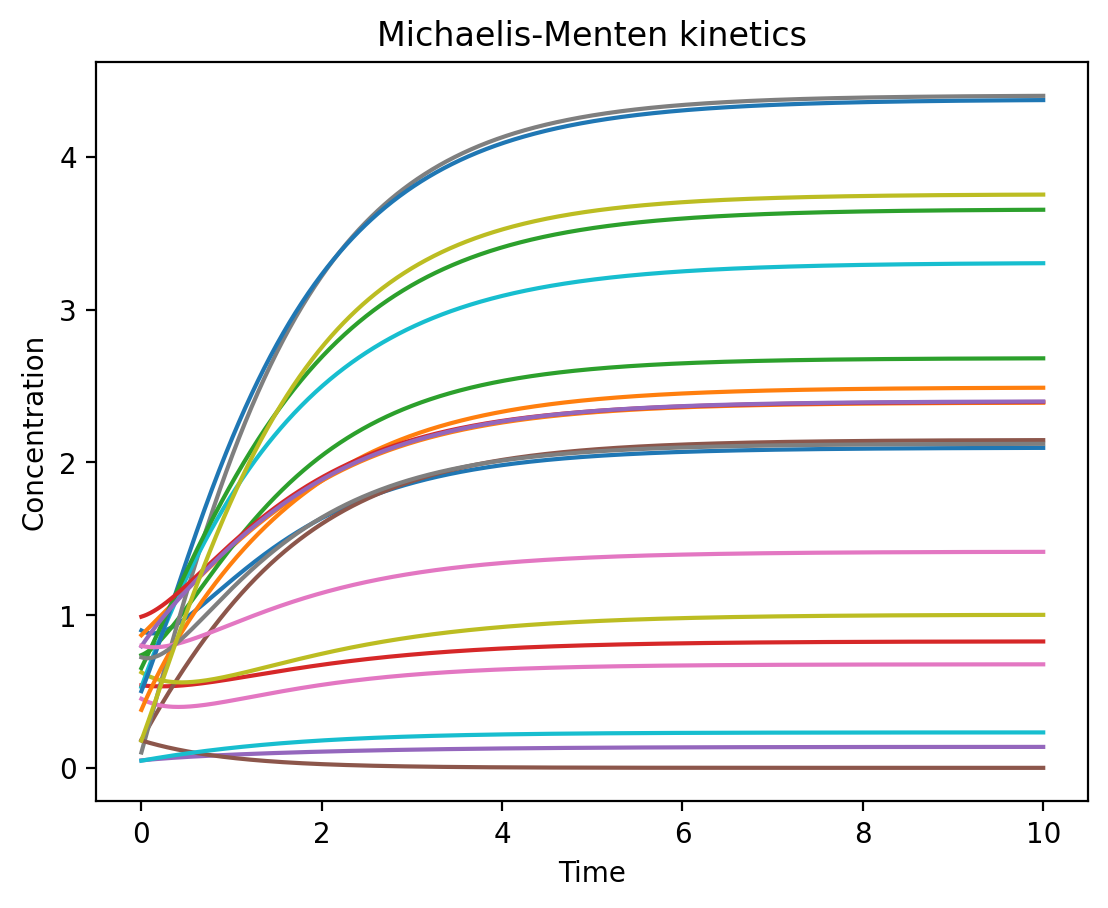

In [196]:
# Plot the results
for i in range(N):
    plt.plot(t, result[:, i], label=f'x_{i}')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Michaelis-Menten kinetics')
plt.show()

In [ ]:
# Plotting the result matrix as a function of time
plt.figure(figsize=(10, 6))
for i in range(result.shape[1]):
    plt.plot(t, result[:, i], label=f'Column {i+1}')

plt.xlabel('Time')
plt.ylabel('Result')
plt.title('Result Matrix as a Function of Time')
plt.show()

In [150]:
# Define the system of ODEs
def system_of_odes(t, y):
    dydt = [0] * len(y)
    # Example: coupled ODEs
    dydt[0] = -0.5 * y[0] + 0.1 * y[1]
    dydt[1] = 0.5 * y[0] - 0.1 * y[1]
    return dydt

# Initial conditions
y0 = [1, 0]

# Time span
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Solve the system of ODEs
solution = solve_ivp(ode_system, t_span, vector, t_eval=t_eval, args=(W,))

# Plotting the result matrix as a function of time
plt.figure(figsize=(10, 6))
for i in range(solution.y.shape[0]):
    plt.plot(solution.t, solution.y[i], label=f'Variable {i+1}')

plt.xlabel('Time')
plt.ylabel('Result')
plt.title('Result Matrix as a Function of Time')
plt.legend()

TypeError: object of type 'float' has no len()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# This function returns the derivative of the state vector expressed according to the formula mentioned above.
# x is the "function" (state vector) we wish to solve for.
def ode_system(x, t, W):  # t must be passed even if not used
    N = len(x)  # Get the number of elements in the state vector
    derivative_vector = np.zeros(N)  # Initialize the derivative vector (set zeros as default)
    for i in range(N):  # Loop over each element in the state vector
        # Compute the sum term for the i-th element according to the formula given in the paper
        sum_term = sum(W[i, j] * (x[j] / (1 + x[j])) for j in range(N))
        derivative_vector[i] = -x[i] + sum_term
    return derivative_vector

# Initialize parameters
N = 100  # Set the number of elements in the state vector
vector = np.random.rand(N)  # Create a random initial state vector with values between 0 and 1
norm = np.linalg.norm(vector)
vector = vector / norm  # Normalize the initial state vector to have a norm of 1
W = np.random.uniform(0, 2, (N, N))  # Create a random weight matrix with values uniformly distributed between 0 and 2

# Set up the time points for the simulation
t = np.linspace(0, 6, 1000)  # Create an array of 1000 time points from 0 to 6

# Solve the system of ODEs
result = odeint(ode_system, vector, t, args=(W,))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, result[:, :])
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Michaelis-Menten kinetics')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate the initial condition vector with random values
initial_conditions = np.random.rand(10)  # Example: 10 random values

# Step 2: Plot the graph using the initial condition vector
plt.plot(initial_conditions)
plt.title('Graph with Initial Condition Vector')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# This function returns the derivative of the state vector expressed according to the formula mentioned above.
# x is the "function" (state vector) we wish to solve for.
def ode_system(x, t, W):  # t must be passed even if not used
    N = len(x)  # Get the number of elements in the state vector
    derivative_vector = np.zeros(N)  # Initialize the derivative vector (set zeros as default)
    for i in range(N):  # Loop over each element in the state vector
        # Compute the sum term for the i-th element according to the formula given in the paper
        sum_term = sum(W[i, j] * (x[j] / (1 + x[j])) for j in range(N))
        derivative_vector[i] = -x[i] + sum_term
    return derivative_vector

# Initialize parameters
N = 100  # Set the number of elements in the state vector
vector = np.random.rand(N)  # Create a random initial state vector with values between 0 and 1
norm = np.linalg.norm(vector)
vector = vector / norm  # Normalize the initial state vector to have a norm of 1
W = np.random.uniform(0, 2, (N, N))  # Create a random weight matrix with values uniformly distributed between 0 and 2

# Set up the time points for the simulation
t = np.linspace(0, 6, 1000)  # Create an array of 1000 time points from 0 to 6

# Solve the system of ODEs
result = odeint(ode_system, vector, t, args=(W,))

# Plot the mean concentration over time
mean_concentration = np.mean(result, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(t, mean_concentration)
plt.xlabel('Time')
plt.ylabel('Mean Concentration')
plt.title('Michaelis-Menten kinetics')
plt.show()

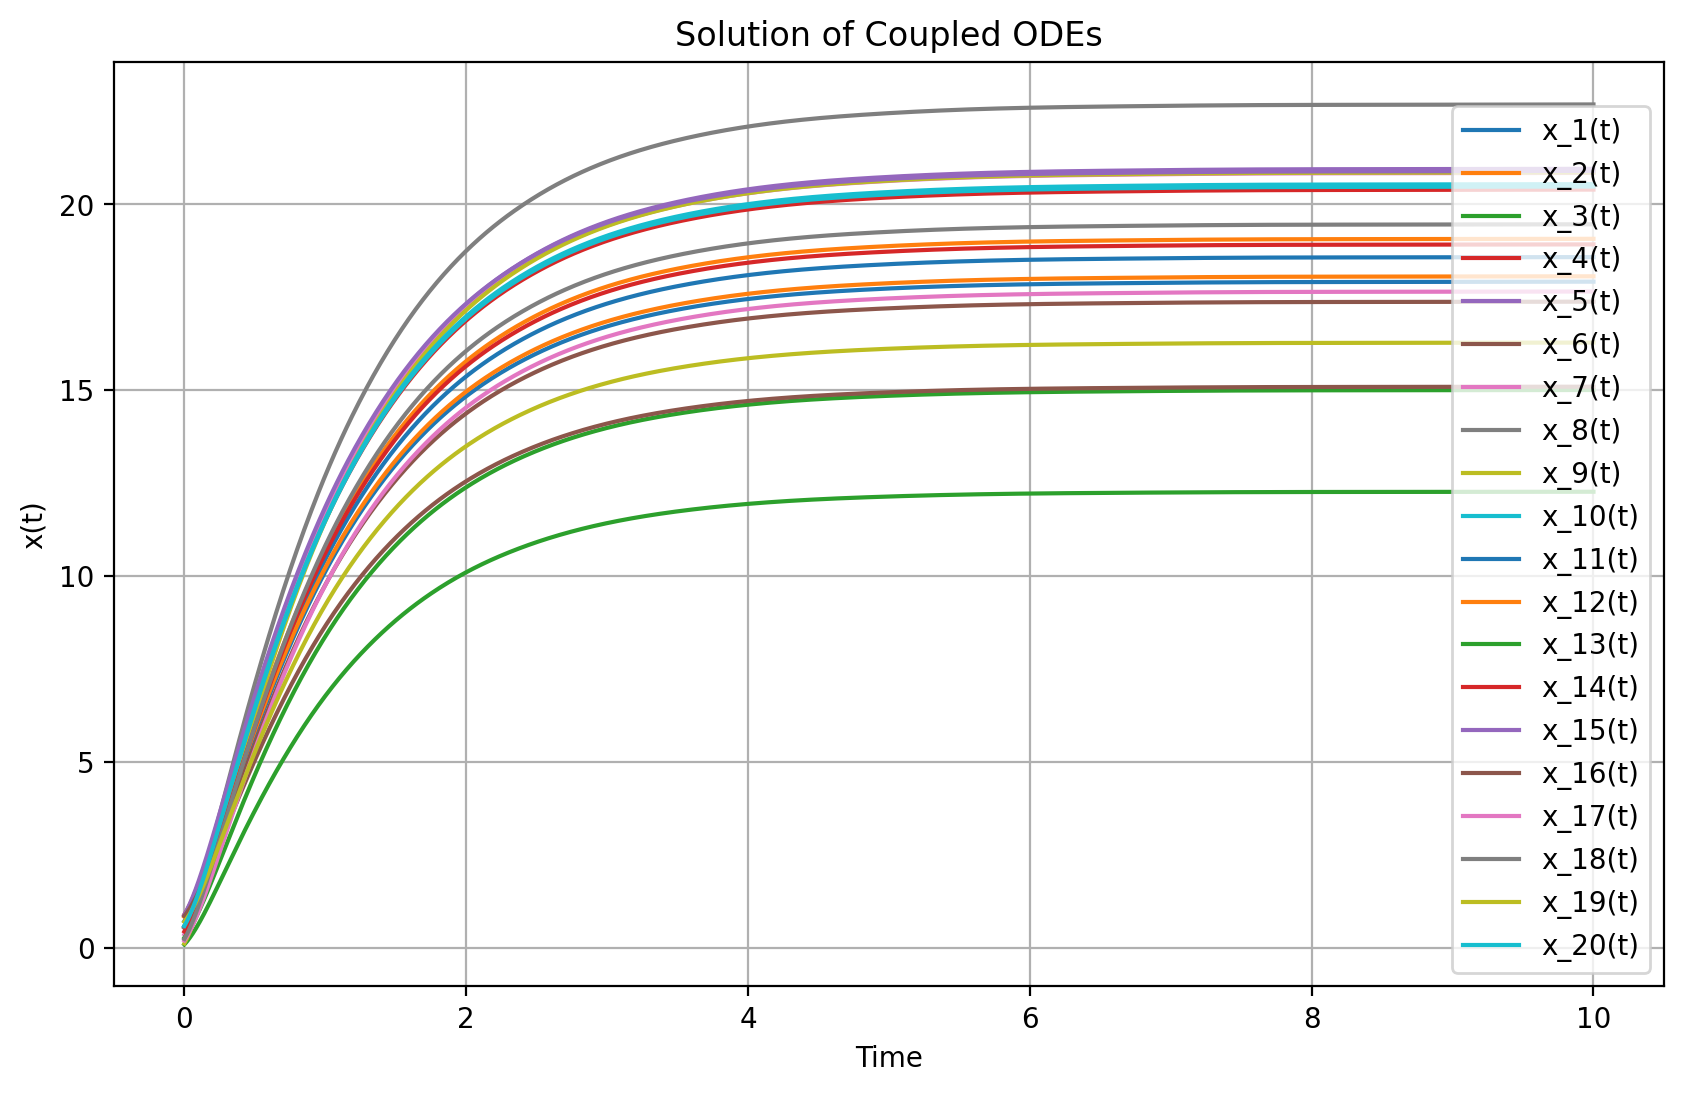

In [151]:
def coupled_odes(t, x, w):
    N = len(x)
    dx_dt = np.zeros(N)
    for i in range(N):
        dx_dt[i] = -x[i] + sum(w[i, j] * x[j] / (1 + x[j]) for j in range(N))
    return dx_dt

def solve_coupled_odes(w, x0, t_span, t_eval):
    N = len(x0)

    solution = solve_ivp(
        fun=lambda t, x: coupled_odes(t, x, w),
        t_span=t_span,
        y0=x0,
        t_eval=t_eval,
        method='RK45'  # You can change this to other methods if needed
    )

    return solution

# Example usage
N = 20  # Number of coupled ODEs
w = np.random.uniform(0, 2, (N, N))  # Example weight matrix
x0 = np.random.rand(N)  # Initial conditions
t_span = (0, 100)  # Time span for integration
t_eval = np.linspace(0, 10, 1000)  # Time points at which to evaluate the solution

solution = solve_coupled_odes(w, x0, t_span, t_eval)

# Plotting the results
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(solution.t, solution.y[i], label=f'x_{i+1}(t)')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Solution of Coupled ODEs')
plt.legend()
plt.grid(True)
plt.show()